# Imports

## Packages

In [1]:
import os
import cvxpy as cp
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from numpy import linalg
import pandas as pd
import astropy
import datetime as dt
from astropy.coordinates import EarthLocation
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import seaborn as sns
import scipy.stats as stats
import random
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib import animation, rc
import plotly.graph_objects as go
from IPython.display import HTML
from sklearn import linear_model
import plotly.graph_objects as go
import networkx as nx
import plotly.express as px
plt.rcParams.update({'font.size': 13})

## Global Variables

In [370]:
from AirLib import data_accessories
# , AIRLINE_DATA

global CODES, NAMES, CLRS, AIRLINE_DATA
CODES = ['WN','DL','AA','OO','UA','YX',
         'B6','MQ','OH','AS','9E','YV',
         'NK','EV','F9','G4','HA']
NAMES = ['Southwest', 'Delta', 'American', 
         'SkyWest', 'United', 'Midwest', 
         'Jet Blue', 'Am. Eagle', 'PSA', 
         'Alaska', 'Endeavor','Mesa', 'Spirit', 
         'ExpressJet', 'Frontier', 'Allegiant', 
         'Hawaiian']
CLRS = sns.color_palette("tab10", len(CODES))

## Classes

In [962]:
class clean_raw_data:
    
    # reading from data_accessories
    ap_info = data_accessories.ap_info 
    
    def __init__(self, airports, routes, fares, delays):
        
        # reading/cleaning data
        self.airports = airports
        self.routes = routes
        self.fares = fares
        self.delays = self.process_delays(delays)
        self.make_airport_coords()
        
    def make_airport_coords(self):
        
        ''' 
        Merging additional information with given airport 
        info. Adding airport name as well as lat/lon data.
        '''
        airport_name = [] ; lat = [] ; lon = []
        x = [] ; y = [] ; z = []
        for AP in self.airports['Airport'].unique():
            
            ap_i = self.ap_info[self.ap_info['AIRPORT'] == AP].iloc[-1] 
            airport_name.append(ap_i['DISPLAY_AIRPORT_NAME'])
            
            # gettinbg airport latitude and longitude
            lon_i = ap_i['LONGITUDE']
            lat_i = ap_i['LATITUDE']
            
            
            # converts to geocentric coordinates meters
            geo_centr = EarthLocation(lon_i, lat_i).value 
            
            lat.append(lat_i)
            lon.append(lon_i) 
            x.append(geo_centr[0])
            y.append(geo_centr[1])
            z.append(geo_centr[2])
           
        # lat / long data
        self.airports['airport_name'] = airport_name
        self.airports['lon'] = lon
        self.airports['lat'] = lat
        
        # geocentric cartesian coordinates (meters)
        self.airports['x'] = x
        self.airports['y'] = y
        self.airports['z'] = z
        
    def process_delays(self, data):
        # getting rid of nan
        self.delays = data.dropna(subset=['ARR_DELAY','DEP_DELAY'])
        data['datetime'] = pd.to_datetime(data['FL_DATE'])
        data = data[data['CANCELED'] != 1]
        return data.fillna(0)
    
class prep_delay_data:

    def __init__(self, data, carrier, N_airports):
        self.carrier = carrier
        self.N_airports = N_airports
        self.top_airports = self.find_top_aps(data)
        self.delay_matr = self.clean_and_format(data)  
        
    def summarize(self):
        pass
    
    def find_top_aps(self, data):
        top_airports = {}
        for i in range(len(CODES)):
            carr = CODES[i]
            sub = AIRLINE_DATA.delays[AIRLINE_DATA.delays['CARRIER'] == carr]
            ap_counts = sub['ORIGIN'].value_counts()
            top_airports[carr] = ap_counts.index[:self.N_airports]
        return list(top_airports[self.carrier])
    
    def clean_and_format(self, data):
        data['datetime'] = pd.to_datetime(data['datetime'])
        subset_0 = data[((data['airport']).isin(self.top_airports)) & 
                        (data['carrier'] == self.carrier)]
        
        '''~ dropping bad dates ~'''
        # if a given airport has 0 flights on some, 
        # remove all flights on that day
        bad_index = []
        for ap in subset_0['airport'].unique():
            sub = subset_0[subset_0['airport'] == ap]['avg_dep']
            nan_rows = pd.isna(sub)
            nan_inds = nan_rows[nan_rows == True].index
            bad_index.extend(list(nan_inds))

        bad_dates = subset_0['datetime'].loc[bad_index]
        inds_to_drop = subset_0[subset_0['datetime'].isin(bad_dates)].index
        subset_1 = subset_0.drop(inds_to_drop)
        #print('Number of rows dropped:',len(subset_0)-len(subset_1))
        
        '''~ log transforming ~ & ~ making delay matrix ~'''
        trans_rows = []
        delay_matr = pd.DataFrame()
        diff_matr = pd.DataFrame()
        matr = []
        for ap in self.top_airports:
            sub = subset_1[subset_1['airport'] == ap]
            # airport wise transformation, each airport X_i ~ N(0,sigma**2)
            delays = sub['avg_dep'].values
            shift = abs(delays.min())+1
            delays += shift
            delays = np.log(delays)
            mu_log = np.mean(delays)
            delays -= mu_log
            
            # making matr object (cleaned and transformed version of original input)
            # note that delay_matr is just a table of delays with no info about time etc
            sub['avg_dep'] = np.log(sub['avg_dep']+shift)-mu_log
            
            # making matrs
            delay_matr[ap] = delays
            diff_matr[ap] = pd.Series(delays).diff(1)[1:]
            # appending data
            matr.append(sub)
            trans_rows.append({'airport': ap,
                               'shift': shift,
                               'mu_log': mu_log})
                                  
        self.trans_df = pd.DataFrame(trans_rows)
        self.matr = pd.concat(matr)
        self.matr['raw_avg_dep'] = subset_1['avg_dep']
        self.diff_matr = diff_matr
        '''~ sorting based on distances ~'''
        unsorted_aps = delay_matr.columns 
        rltv_dists = []
        rfrnce_ap = unsorted_aps[0]
        for ap_i in unsorted_aps:
            if ap_i != rfrnce_ap:
                # trying to see if there is an actual flight, if not, set 1e6 distance
                try:
                    subset = AIRLINE_DATA.routes[
                        (AIRLINE_DATA.routes['ORIGIN'] == rfrnce_ap) & 
                        (AIRLINE_DATA.routes['DEST'] == ap_i)
                        ]
                    d = subset['DISTANCE'].values[0]
                    rltv_dists.append({'airport': ap_i, 'distance': d})
                except:
                    rltv_dists.append({'airport': ap_i, 'distance': 1e6})
            else:
                rltv_dists.append({'airport': rfrnce_ap, 'distance': 0})

        dist_df = pd.DataFrame(rltv_dists).sort_values(by = ['distance'])
        delay_matr = delay_matr[dist_df['airport']]
        
        return delay_matr
    
class visual:
    '''
    Note that this class takes multiple different kinds of
    data. It will not execute if you call a plotting method
    that doesnt math the data type (dataframe with correct columns)
    '''
    def __init__(self, data, carrier):
        self.data = data
        self.carrier = carrier
        self.index = CODES.index(carrier)
        
    def flight_frequency(self):
        dates = self.data['FL_DATE'].unique()
        counts = self.data['ORIGIN'].value_counts()/len(dates)
        aps = counts.index

        fig = go.Figure(data=[go.Bar(
                x=aps, y=counts,
                marker_color=['rgb{}'.format(CLRS[self.index]) for i in range(len(aps))])
                         ])
        fig.update_layout(
            title="{} - Flights Per Day ({}, {})".format(NAMES[self.index], dates[0], dates[-1]),
            plot_bgcolor="white", 
            width = 950, height = 500)
        
        color = 'rgb(209, 209, 209)'
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor=color)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor=color)
        fig.show()
        
    def time_series(self):
        fig = go.Figure()
        for c in self.data['airport'].unique():
            sub = self.data[self.data['airport'] == c]
            fig.add_trace(go.Scatter(
                            x = sub['datetime'],
                            y = sub['avg_dep'],
                            name = c,
                            opacity=.9))

        fig.update_layout(title = '{} - Mean Delay'.format(NAMES[self.index]),
                          xaxis_range=[
                              self.data['datetime'].min(),
                              self.data['datetime'].max()
                          ],
                         xaxis_rangeslider_visible=True,
                         width = 950, height = 600, 
                         plot_bgcolor = "white")
        color = 'rgb(209, 209, 209)'
        fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor=color)
        fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor=color)
        fig.show()
        
    def cov_matr(self):
        # airpots, covariance & precision matrix
        aps = self.data.columns
        cov_matr = np.corrcoef(self.data.T)
        prec_matr = linalg.inv(cov_matr)
        
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (18,7))
        sns.heatmap(cov_matr, ax = ax0, center=0, 
                    xticklabels = aps, yticklabels = aps)
        sns.heatmap(prec_matr, ax = ax1, center=0, 
                    xticklabels = aps, yticklabels = aps)
        plt.show()
        
    def dist_corr(self):
        aps = list(self.data.columns)
        cov_matr = np.corrcoef(self.data.T)
        prec_matr = linalg.inv(cov_matr)
        pairs = []
        for i in aps:
            for j in aps:
                if i!=j and (j, i) not in pairs:
                    pairs.append((i,j))

        values = []
        for p in pairs:
            subset = AIRLINE_DATA.routes[
                (AIRLINE_DATA.routes['ORIGIN'] == p[0]) & 
                (AIRLINE_DATA.routes['DEST'] == p[1])]
            d = subset['DISTANCE'].values
            
            if len(d) > 0:
                values.append({'distance': d[0],
                             'corr': cov_matr[aps.index(p[0])][aps.index(p[1])],
                             'origin': p[0],
                             'dest': p[1]})

        dist_corr = pd.DataFrame(values)
        plt.figure(figsize = (10,6))
        plt.grid(b=True, which='major', color='grey', linewidth=0.3)
        plt.grid(b=True, which='minor', color='grey', linewidth=0.3)
        plt.scatter(dist_corr['distance'], dist_corr['corr'], s = 40, color = 'k')
        plt.xlabel('Distance', fontsize = 17)
        plt.ylabel('Correlation', fontsize = 17)
        plt.show()

In [980]:
class meinhausen_bulman:
    def __init__(self, delay_matr, carrier, lambd):
        self.delay_matr = delay_matr
        self.carrier = carrier
        self.lambd = lambd
        self.nodes = list(delay_matr.columns)
        self.params = self.estimate_parmeters()
        self.edges = self.stitch_edges()
        
    def estimate_parmeters(self):
        params = {}
        for node_i in self.nodes:
            data_i = self.delay_matr[node_i]
            data_rest = self.delay_matr[[i for i in self.nodes if i != node_i]]
            lassoreg_i = linear_model.Lasso(self.lambd)
            lassoreg_i.fit(data_rest, data_i)
            params[node_i] = lassoreg_i.set_params()
        return params
            
    def stitch_edges(self):
        delta = 0.01
        edges = pd.DataFrame()
        for node_i, model_i in self.params.items():
            ind = list(self.params.keys()).index(node_i)
            coeffs = [i if abs(i) >= delta else 0 for i in model_i.coef_]
            coeffs.insert(ind, 1)
            edges[node_i] = coeffs

        for node_i in self.nodes:
            for node_j in range(len(self.nodes)):
                edge_pair = [edges[node_i].iloc[node_j], 
                             edges[self.nodes[node_j]].iloc[self.nodes.index(node_i)]]
                max_edge = max(edge_pair)
                edges[node_i].iloc[node_j] = max_edge
                edges[self.nodes[node_j]].iloc[self.nodes.index(node_i)] = max_edge
        return edges
    
    def view_graph(self, g_type):
        N = self.nodes
        
        G=nx.Graph()
        G.add_nodes_from(N)
        routes = MY_DATA[['airport', 'lat', 'lon']].drop_duplicates()
        plotly_rows = []
        for n_i in N:
            for n_j in N:
                if n_i != n_j:
                    weight = self.edges[n_i].iloc[N.index(n_j)]
                    if weight != 0:
                        edge = (n_i, n_j)
                        G.add_edge(n_i, n_j, weight = weight)

                    org = routes[routes['airport'] == n_i]
                    dest = routes[routes['airport'] == n_j]
                    plotly_rows.append({
                        'weight': weight,
                        'start_lon': org['lon'].values[0],
                        'end_lon': dest['lon'].values[0],
                        'start_lat': org['lat'].values[0],
                        'end_lat': dest['lat'].values[0],
                        'start_airport': n_i,
                        'end_airport': n_j
                    })
        plotly_df = pd.DataFrame(plotly_rows).drop_duplicates()
        
        if g_type == 'circular':
            plt.figure(figsize = (2.5,2.5))
            
            nx.draw_circular(G, node_size = 125, 
                             node_color = [CLRS[CODES.index(self.carrier)]], 
                             with_labels=False)
            plt.show(G)
            
        elif g_type == 'geographic':
            sub = plotly_df[['start_airport','start_lat','start_lon']].drop_duplicates()
            inds = plotly_df[[i for i in plotly_df.columns if 'end' not in i]].drop_duplicates().index
            plotly_df = plotly_df.loc[inds]

            fig = go.Figure()
            for ap in sub['start_airport'].unique():
                ap_i = sub[sub['start_airport'] == ap]
                fig.add_trace(
                    go.Scattergeo(
                        locationmode = 'USA-states',
                        lon = ap_i['start_lon'], 
                        lat = ap_i['start_lat'],
                        hoverinfo = 'text',
                        name = ap,
                        mode = 'markers',
                        marker = dict(
                            size = 2,
                            color = 'rgb(0,0,0)',
                            line = dict(width = 3,color = 'rgb(0,0,0)'))
                    )
                )
            line_colors = ['red','green']
            def sign_color(weight):
                if weight >= 0:
                    return 'green'
                else:
                    return 'red'

            flight_paths = []
            for i in range(len(plotly_df)):
                fig.add_trace(
                    go.Scattergeo(
                        locationmode = 'USA-states',
                        lon = [plotly_df['start_lon'].iloc[i], plotly_df['end_lon'].iloc[i]],
                        lat = [plotly_df['start_lat'].iloc[i], plotly_df['end_lat'].iloc[i]],
                        mode = 'lines',
                        name = plotly_df['end_airport'].iloc[i],
                        opacity = 1,
                        line = dict(
                            width = abs(plotly_df['weight'].iloc[i])*5, 
                            color = sign_color(plotly_df['weight'].iloc[i])) 
                    )
                )
            fig.update_layout(
                title = 'Carrier - {}'.format(NAMES[self.index]),
                showlegend = False,
                geo = dict(
                    scope = 'north america',
                    projection_type = 'azimuthal equal area',
                    showland = True,
                    landcolor = 'rgb(230,230,230)',
                    countrycolor = 'rgb(204, 204, 204)'),
                width = 960, height = 700)
            fig.show()

In [964]:
class fuse_lasso:

    DELTA = 0.01
    def __init__(self, flight_data, M, lambd_grid, alpha_grid):
        self.flight_data = flight_data
        self.M = M
        self.nodes = list(M.columns)
        self.T = M.shape[0]
        self.d = M.shape[1]
        self.diff_matr = self.make_diff_matr()
        self.lambd_grid = lambd_grid
        self.alpha_grid = alpha_grid
        self.edge_list = self.edge_estimation()
        self.graphs = self.precision_matricies()
        
    def make_diff_matr(self):
        D = (np.identity(self.T) + np.diag([-1]*(self.T-1),k=1))[:-1]
        return D
    
    def MSE(self, X, y, beta):
        return (.5)*sum([(y[t] - sum([beta[t][i]*X[t][i] for i in range(self.d-1)]))**2 for t in range(self.T)])

    def l1_norm(self, beta):
        return sum([cp.norm1(beta[t]) for t in range(self.T)])

    def fusion(self, beta):
        return sum([cp.norm1(vec) for vec in [self.diff_matr@beta.T[i] for i in range(self.d-1)]])

    def obj_func(self, X, y, beta_matr, _lamda_, _alpha_):
        return self.MSE(X, y, beta_matr) + _lamda_*self.l1_norm(beta_matr) + _alpha_*self.fusion(beta_matr)
    
    def edge_estimation(self):
        estimates = []
        for node_i in self.nodes:
            y = self.M[node_i].to_numpy()
            X = self.M[[j for j in self.nodes if j != node_i]].to_numpy()
            
            # node_i optimization 
            _lambd_ = cp.Parameter(nonneg=True)
            _alpha_ = cp.Parameter(nonneg=True)
            beta_matr = cp.Variable(shape = (self.T, self.d-1))
            optim_problem = cp.Problem(
                cp.Minimize(self.obj_func(X, y, beta_matr, _lambd_, _alpha_))
            )
            
            for l in self.lambd_grid:
                _lambd_.value = l
                for a in self.alpha_grid:
                    _alpha_.value = a
                    optim_problem.solve(solver='ECOS')
                    estimates.append({'node': node_i,
                                     'l': l, 'a': a,  
                                     'error': optim_problem.value, 
                                     'beta_matrix': beta_matr.value})
        return pd.DataFrame(estimates)
    
    def precision_matricies(self):
        omega_list = []
        for t in range(self.T):

            # creaing precision_matrix(t)  
            edges_t = pd.DataFrame()
            for i in range(len(self.edge_list['node'])):
                node_i = self.nodes[i]
                beta_t_i = list(
                    self.edge_list[self.edge_list['node'] == node_i]['beta_matrix'].iloc[0][t]
                )
                beta_t_i.insert(i,1)
                edges_t[node_i] = beta_t_i

            # stitching the edges for each precision_matrix(t)  
            for node_i in self.nodes:
                for node_j in self.nodes:
                    index_i = self.nodes.index(node_i)
                    index_j = self.nodes.index(node_j)
                    max_edge = max([edges_t[node_i].iloc[index_j], 
                                    edges_t[node_j].iloc[index_i]])
                    if max_edge < 0.01:
                        max_edge = 0
                    edges_t[node_i].iloc[index_j] = max_edge
                    edges_t[node_j].iloc[index_i] = max_edge
            omega_list.append(edges_t)
        return omega_list
    
    def plot_paramaters(self, demo = False):
        dates = self.flight_data['datetime'].unique()
        
        num_nodes = len(self.nodes)
        if demo == True:
            num_nodes = 3
        for i in range(num_nodes):
            params = []
            for omega_t in self.graphs:
                indicies = [x for x in range(len(self.nodes)) if x != i]
                params.append(omega_t[self.nodes[i]].iloc[indicies])
            plt.figure(figsize = (13,4))
            plt.plot(dates, params)
            plt.title(self.nodes[i])
            plt.show()
            
    def generate_segments(self, threshold, plot = True):
        omega = self.graphs
        dates = self.flight_data['datetime'].unique()
        omega_delta = [omega[i+1].to_numpy()-omega[i].to_numpy() for i in range(len(omega)-1)]
        
        rows = []
        for i in range(len(omega_delta)):
            Sum = 0
            omega_dt = omega_delta[i]
            for j in range(len(omega_dt)):
                Sum += omega_dt[j].max()
            rows.append({'dates': dates[i], 'value': Sum})
        df = pd.DataFrame(rows)

        if plot == True:
            plt.figure(figsize = (14, 6))
            plt.plot(df['dates'], df['value'], color = 'k')
            plt.title('lambda = {}'.format(self.alpha_grid[0]))
            #plt.hlines(y = threshold, 
            #           xmin = dates[0], xmax= dates[-1], 
             #          color = 'red',
              #         linestyles  = 'dashed',
              #         linewidth = 4)
            plt.show()


        good = df[(df['value'] >= threshold)]
        dates = good['dates']
        bad_dates = []
        for i in range(len(dates)-1):
            if (dates.iloc[i+1]-dates.iloc[i] < dt.timedelta(days = 30)):
                bad_dates.append(dates.iloc[i+1])    

        return good[~(good['dates']).isin(bad_dates)]

## Data

In [26]:
path = os.getcwd() + '\\'

airports0 = pd.read_csv(path + 'Airports.csv')
routes0 = pd.read_csv(path + 'Routes.csv')
fares0 = pd.read_csv(path + 'AirFares.csv')
delays0 = pd.read_csv(path + 'FlightDelays.csv')

AIRLINE_DATA = clean_raw_data(airports0, routes0, fares0, delays0)

C:\Users\Landon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.



In [382]:
MY_DATA = pd.read_csv(path + '\correct_MATR.csv')
MY_DATA['datetime'] = pd.to_datetime(MY_DATA['datetime'])

# First look at the data

In [968]:
print(CODES)

['WN', 'DL', 'AA', 'OO', 'UA', 'YX', 'B6', 'MQ', 'OH', 'AS', '9E', 'YV', 'NK', 'EV', 'F9', 'G4', 'HA']


In [969]:
num_airports = 30
carrier = 'OO'

In [970]:
X = prep_delay_data(MY_DATA, carrier, num_airports)

matr = X.matr
delay_matr = X.delay_matr

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



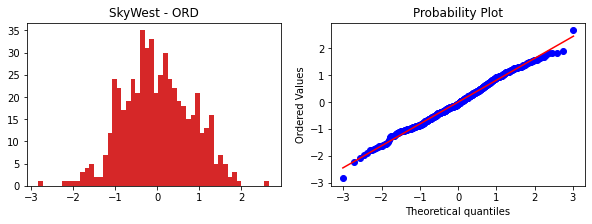

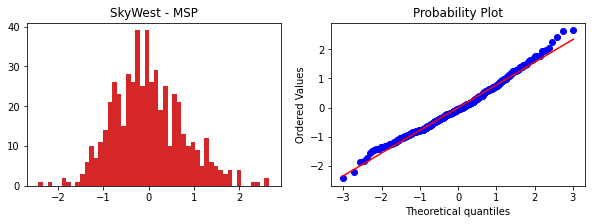

In [971]:
top_3 = X.top_airports

y = delay_matr[top_3[0]]
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,3))
ax0.hist(y, bins = 50, color = CLRS[CODES.index(carrier)])
ax0.set_title('{} - {}'.format(f'{NAMES[CODES.index(carrier)]}', top_3[0]))
stats.probplot(y, dist=stats.norm, plot=ax1)
plt.show()

y = delay_matr[top_3[2]]
fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10,3))
ax0.hist(y, bins = 50, color = CLRS[CODES.index(carrier)])
ax0.set_title('{} - {}'.format(f'{NAMES[CODES.index(carrier)]}',top_3[2]))
stats.probplot(y, dist=stats.norm, plot=ax1)
plt.show()

In [972]:
raw_subset = AIRLINE_DATA.delays[
    (AIRLINE_DATA.delays['CARRIER'] == carrier) & 
    ((AIRLINE_DATA.delays['ORIGIN']).isin(X.top_airports))
]

visual(raw_subset, carrier).flight_frequency()

In [973]:
visual(matr, carrier).time_series()

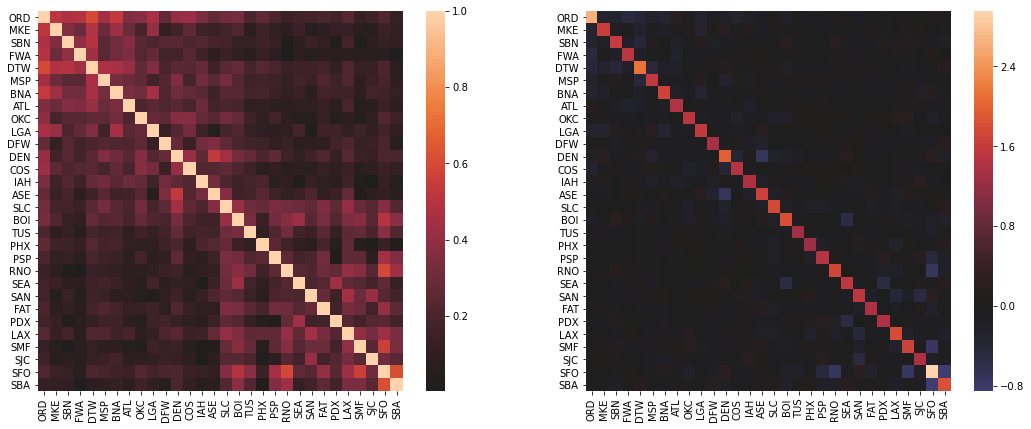

In [974]:
V = visual(delay_matr, carrier)
V.cov_matr()

# make sure to note that this is distance based from MDW
# the distance plot is relative distance

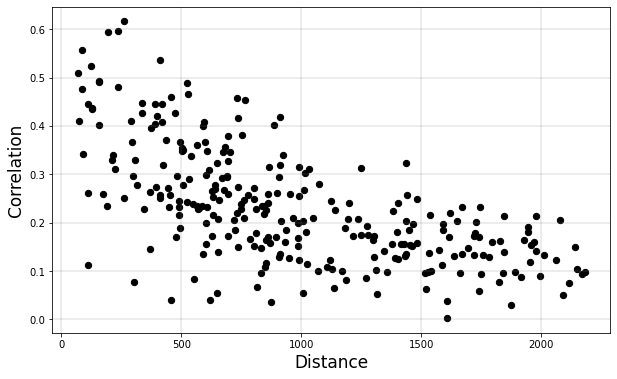

In [975]:
V.dist_corr()

In [976]:
MB = meinhausen_bulman(delay_matr, carrier, .2)
MB.view_graph('geographic')

C:\Users\Landon\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Users\Landon\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



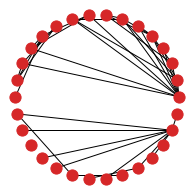

In [977]:
MB.view_graph('circular')

# Segmentation 

In [978]:
lambd = [.07]
alpha = [4]

model = fuse_lasso(matr, delay_matr, lambd, alpha)

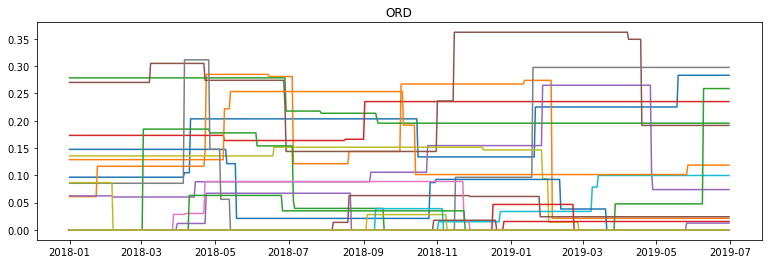

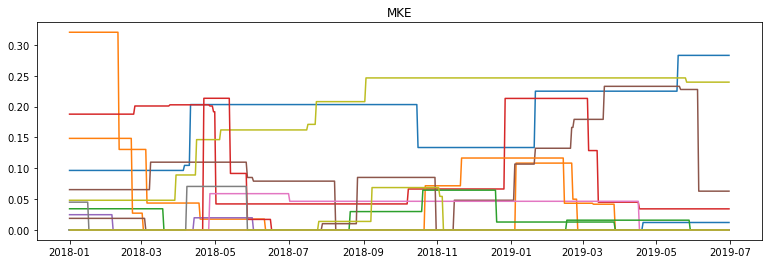

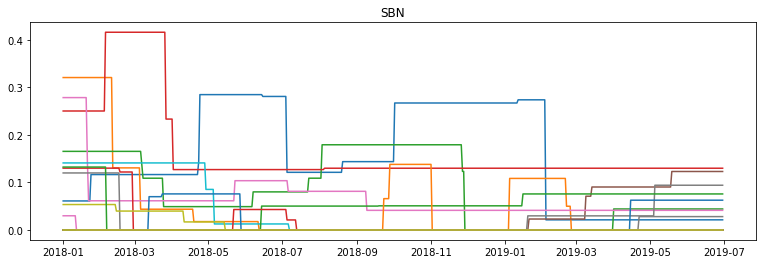

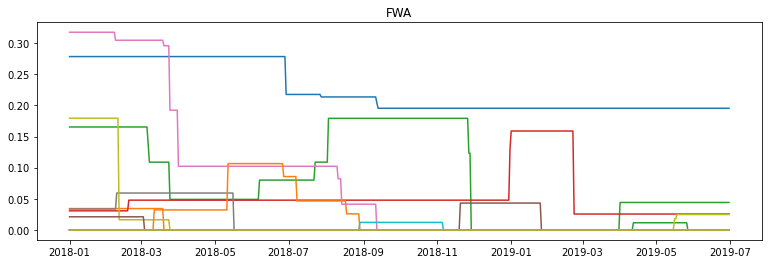

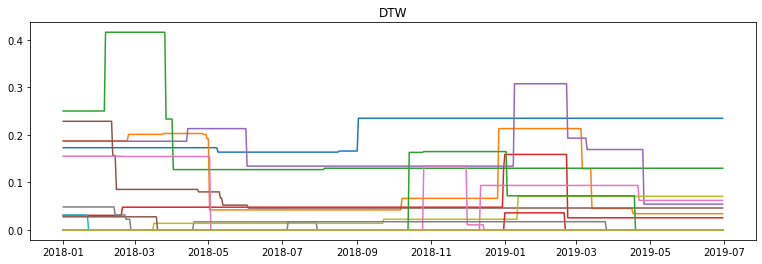

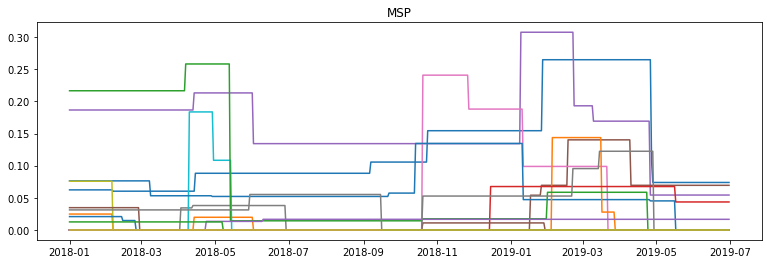

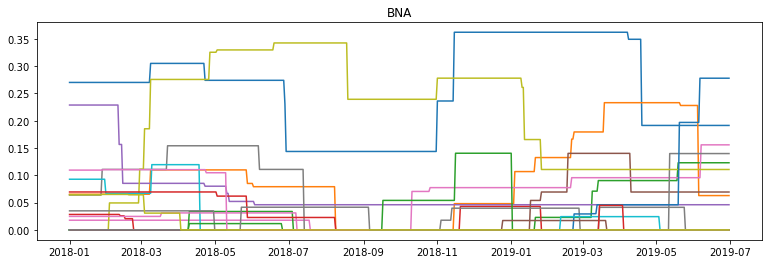

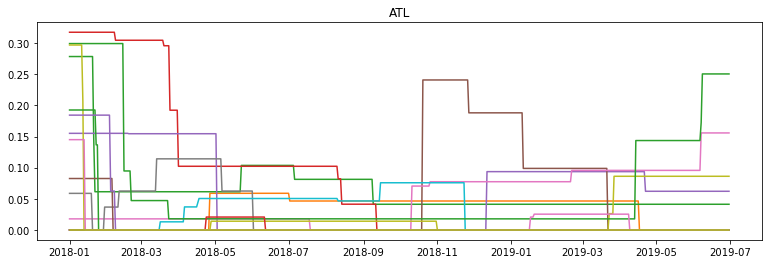

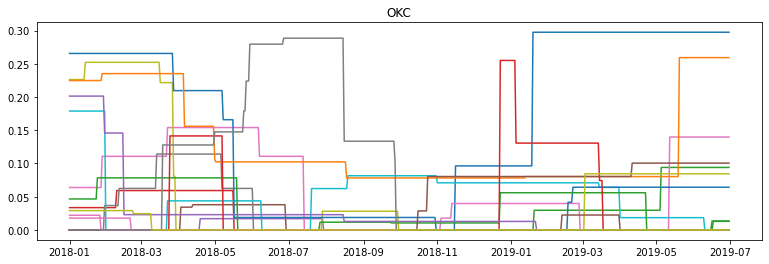

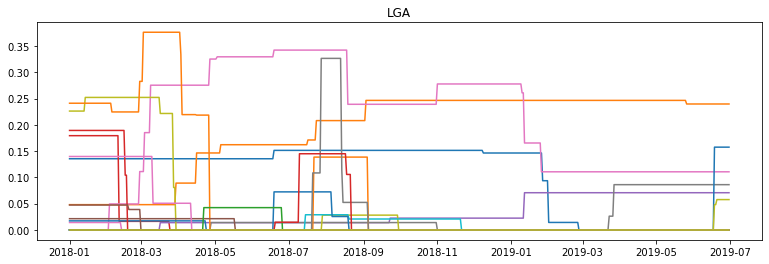

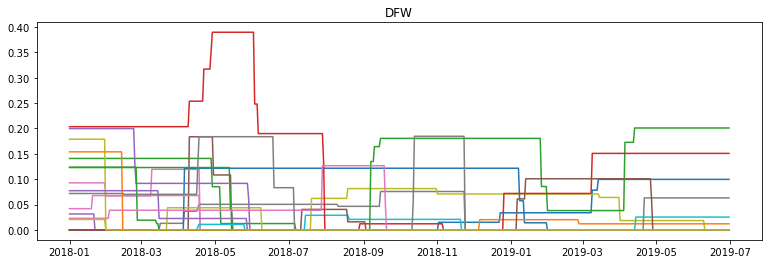

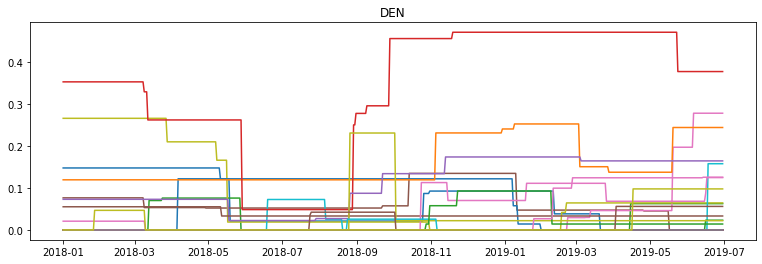

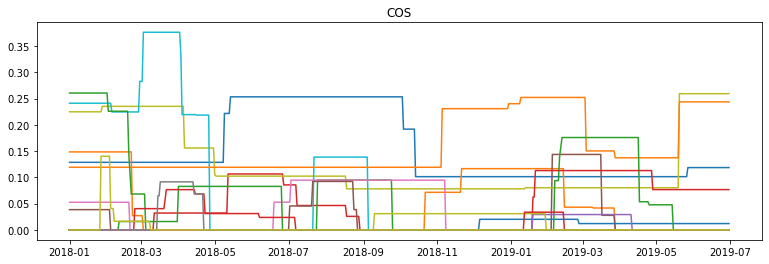

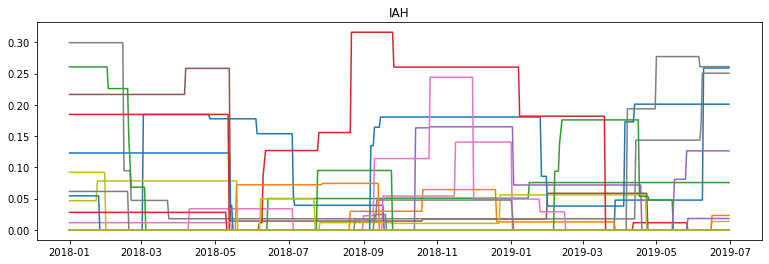

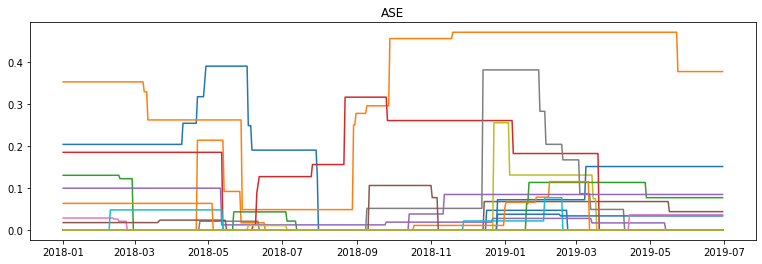

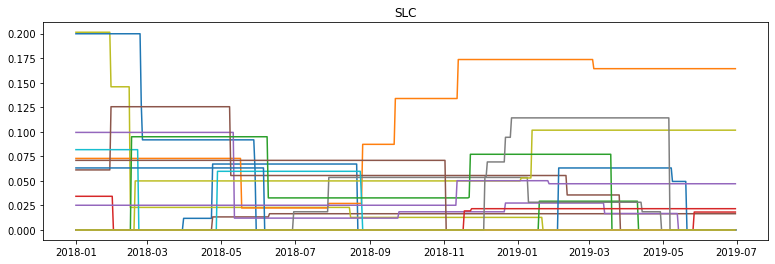

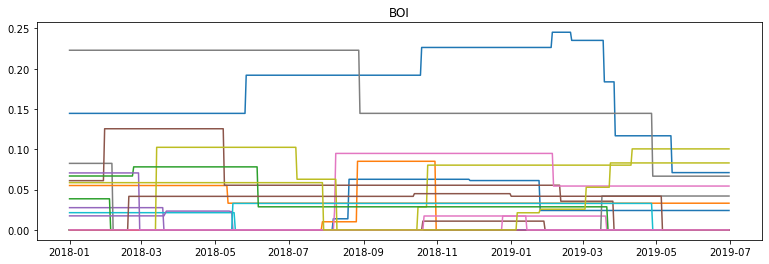

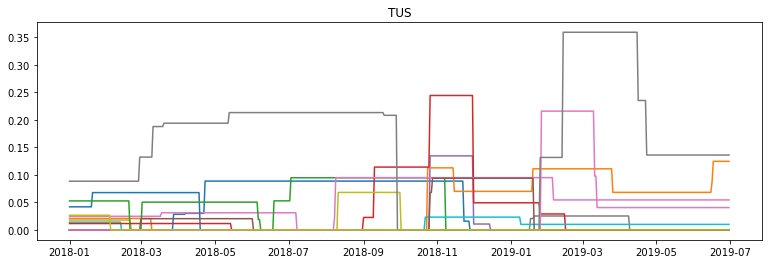

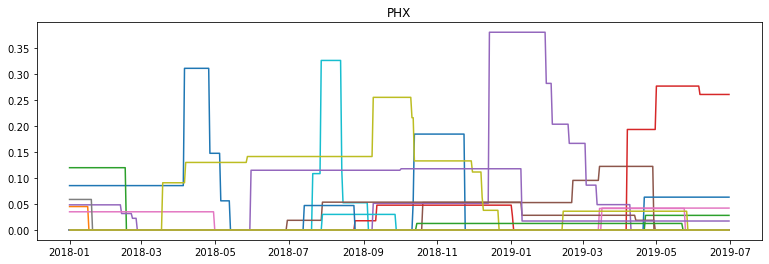

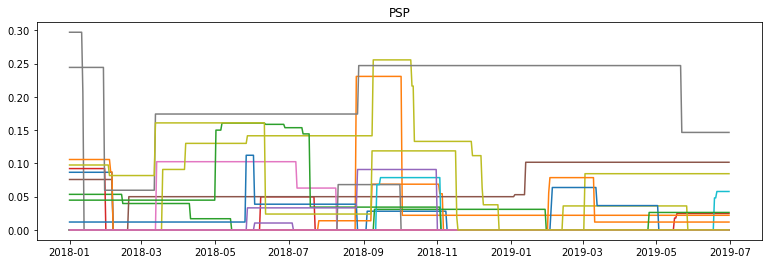

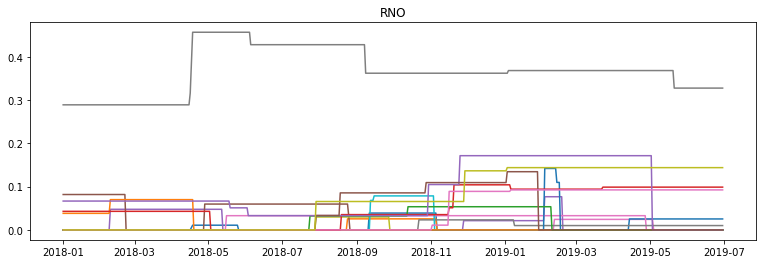

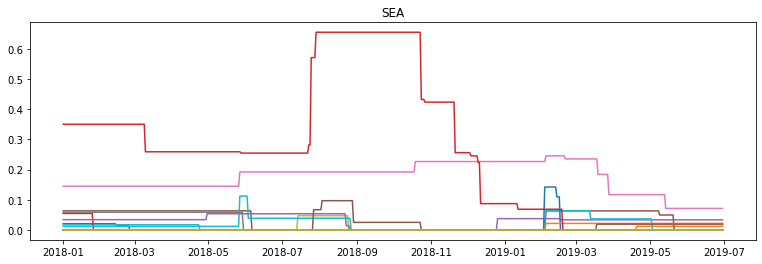

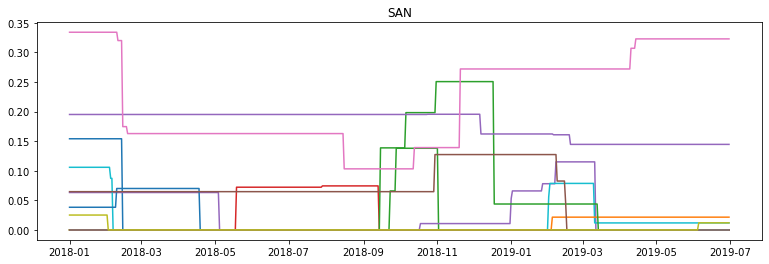

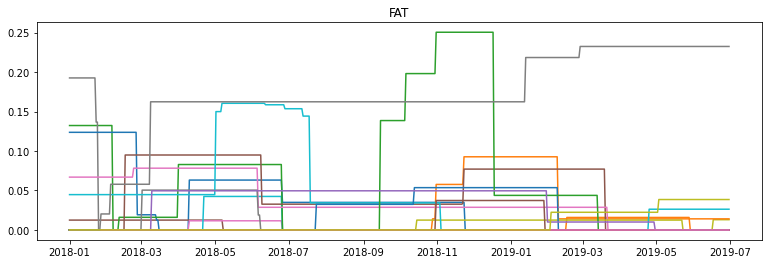

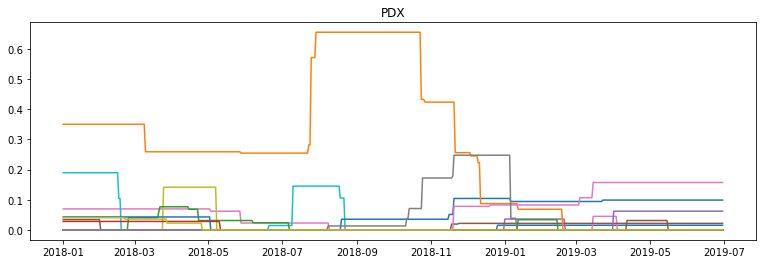

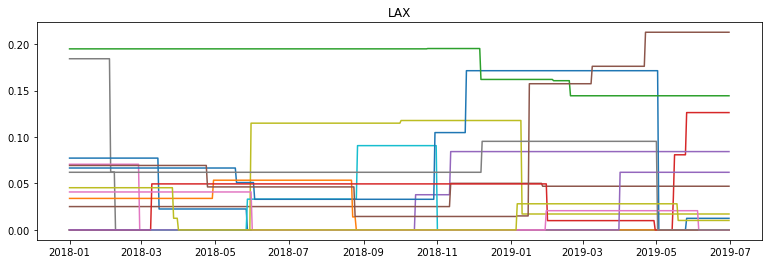

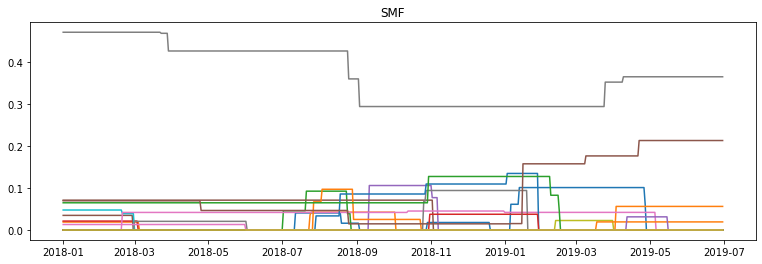

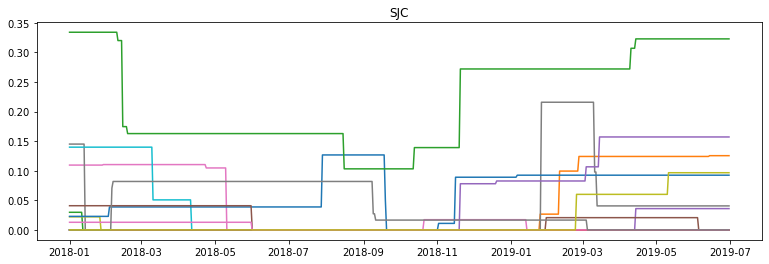

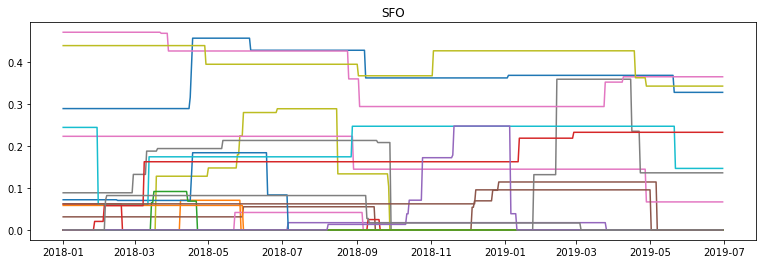

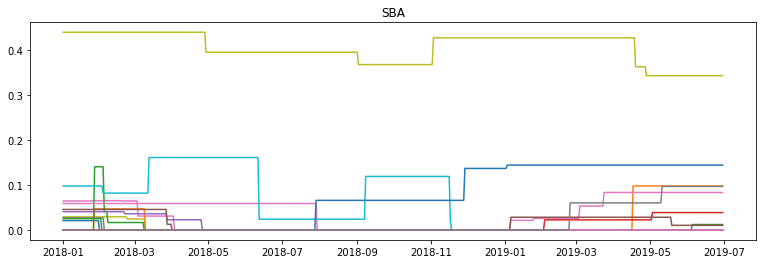

In [981]:
omega_list = model.graphs
model.plot_paramaters(demo = False)

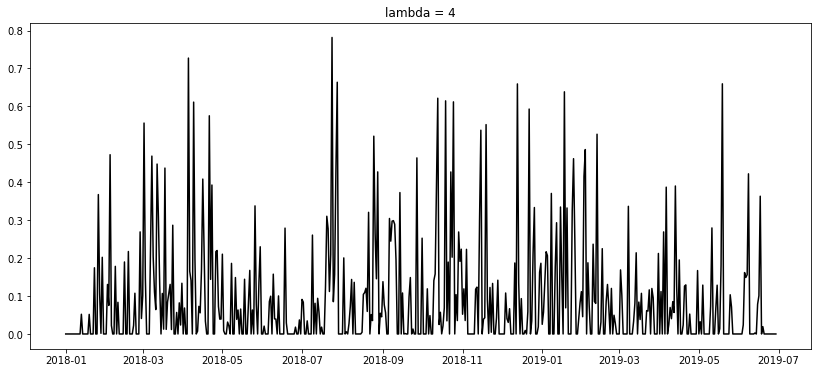

In [983]:
segs = model.generate_segments(.5)['dates']

# Vector Autoregressive Modelling

In [984]:
delay_matr.index = matr['datetime'].unique()

sub = matr[(matr['datetime'] >= pd.to_datetime('2018-07-01')) & 
    (matr['datetime'] <  pd.to_datetime('2018-11-01'))
]

df = pd.DataFrame()
for ap in sub['airport'].unique():
    df[ap] = sub[sub['airport'] == ap]['avg_dep'].values

In [985]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

lag = 1
vmodel = VAR(df)
results = vmodel.fit(lag)

## Granger Causality

In [986]:
row = []
for ap in X.top_airports:
    other_aps = [i for i in X.top_airports if i != ap]
    if aps[0] != aps[1]:
        GC_test = results.test_causality(caused = ap, causing = other_aps).summary()
        pvalue = GC_test.data[1::2][0][-2]
        row.append({'caused': ap, 'pval': pvalue})
GC_df = pd.DataFrame(row).sort_values(by = ['pval'])

In [987]:
alpha = 0.05
signif = GC_df[GC_df['pval'] <= alpha]
signif

,caused,pval
21,COS,0.010051
27,SBN,0.014456
29,RNO,0.022276
16,BNA,0.027764


# 2019 Q3 Predictions

In [988]:
data = pd.read_csv(path+'raw_q3.csv')

In [989]:
Q3_raw = clean_raw_data(airports0, routes0, fares0, data)

In [992]:
Q3_DATA = pd.read_csv(path + 'q3_delay_MATR.csv')
Q3_DATA['datetime'] = pd.to_datetime(Q3_DATA['datetime'])

Q3_DATA = Q3_DATA[
    (Q3_DATA['datetime'] >= pd.to_datetime('2019-07-01')) & 
    (Q3_DATA['datetime'] <  pd.to_datetime('2019-10-01'))
]

In [997]:
num_airports = 10
carrier = 'OO'

In [998]:
Y = prep_delay_data(Q3_DATA, carrier, num_airports)

matr_q3 = Y.matr
delay_matr_q3 = Y.delay_matr

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [999]:
visual(matr_q3, carrier).time_series()

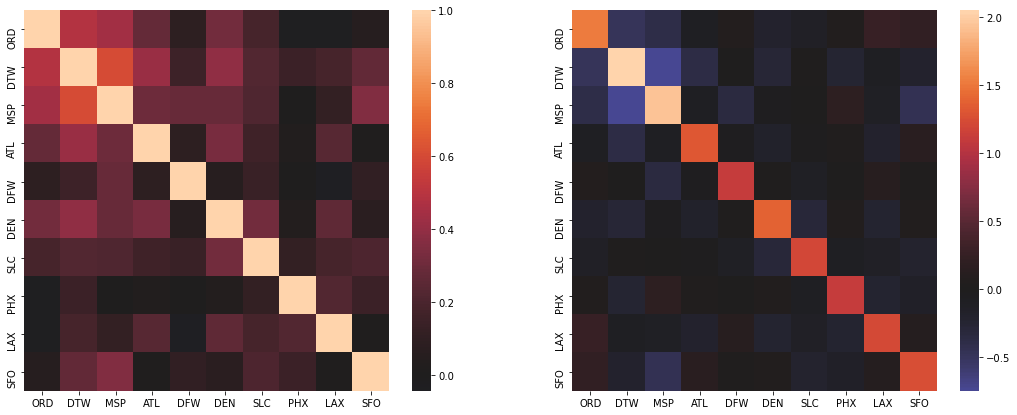

In [1000]:
V = visual(delay_matr_q3, carrier)
V.cov_matr()

In [1002]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from itertools import combinations

class VAR_model:
    def __init__(self, train, test, segments, carrier, lag = 1):
        self.trans_train = train.trans_df
        self.train_info = train.matr
        self.train_delays = train.delay_matr
        self.airports = train.delay_matr.columns
        
        self.trans_test = test.trans_df
        self.test_info = test.matr
        self.test_delays = test.delay_matr
        self.segments = segments
        
        self.carrier = carrier
        self.lag = lag
        
        
        self.train_diff = train.diff_matr
        self.test_diff = test.diff_matr
        
        self.predicted = self.generate_predictions()
        
    def estimate_VAR(self, data):
        return VAR(data).fit(self.lag)
    
    def transform(self, data, DIFF, Type, airport):
        
        if Type == 'train':
            
            df = self.trans_train
            params = df[df['airport'] == airport]
            new_data = np.exp(data+params['mu_log'].iloc[0])+params['shift'].iloc[0]

        elif Type == 'test':
            data = data[1:]
            DIFF = self.test_diff[airport]
            df = self.trans_test
            params = df[df['airport'] == airport]
            new_data = np.exp(DIFF+data+params['mu_log'].iloc[0])+params['shift'].iloc[0]

            #new_data = np.exp(DIFF+data+params['mu_log'].iloc[0])+params['shift'].iloc[0]
        return new_data
    
    def generate_predictions(self):
        
        X = self.train_delays
        X.index = self.train_info.datetime.unique()
        Y = self.test_delays
        Y.index = self.test_info.datetime.unique()
        time_delta = dt.timedelta(days = 365)
        
        diff_X = self.train_diff
        diff_X.index = self.train_info.datetime.unique()[1:]
        diff_Y = self.test_diff
        diff_Y.index = self.test_info.datetime.unique()[1:]
        
        rolling_preds = [] ; rolling_dates = []
        rolling_granger = []
        for i in range(len(self.segments)-1):
            dates = []
            t0 = self.segments[i]
            t1 = self.segments[i+1]            
            sub_train = X[(X.index >= t0) & (X.index < t1)]
            sub_test = Y[(Y.index >= t0+time_delta) & (Y.index < t1+time_delta)]

            if len(sub_test) >= 2:
                predictions = pd.DataFrame()
                model_t = VAR(sub_train)
                results = model_t.fit(self.lag)
                for i in range(len(sub_test)-self.lag-1):
                    obs_i = sub_test.iloc[i:i+self.lag].to_numpy()
                    predictions[sub_test.index[i+self.lag]] = results.forecast(obs_i, 1)[0]
                    dates.extend(sub_test.index[i:i+self.lag])
                    
                row = []
                for ap in self.airports:
                    other_aps = [i for i in self.airports if i != ap]
                    if aps[0] != aps[1]:
                        GC_test = results.test_causality(caused = ap, causing = other_aps).summary()
                        pvalue = GC_test.data[1::2][0][-2]
                        row.append({'caused': ap, 'pval': pvalue})
                GC_df = pd.DataFrame(row).sort_values(by = ['pval'])                
                predictions.index = sub_test.columns
                predictions = predictions.T
                rolling_dates.extend(dates)
                rolling_preds.append(predictions)
                rolling_granger.append(GC_df)
        self.granger = rolling_granger
        predictions = pd.concat(rolling_preds)
        t0_new = rolling_dates[0]
        t1_new = rolling_dates[-1]
        self.observed = Y[(Y.index >= t0_new) & (Y.index < t1_new)]
        
        diff_X = diff_X[(diff_X.index > t0_new-time_delta)  & (diff_X.index <= t1_new-time_delta)]
        diff_Y = diff_Y[(diff_Y.index > t0_new)  & (diff_Y.index <= t1_new)]
        #print(self.observed.index[:3])
        #print(diff_X.index[:3])
        #print(predictions.index[:3])
        #print(diff_Y.index[:3])
        for ap in self.airports:
            self.observed[ap] = self.transform(self.observed[ap], None,  'train', ap)
            predictions[ap] = self.transform(predictions[ap], diff_X[ap], 'test', ap)
        predictions.index += dt.timedelta(days = 1)
        
        return predictions.iloc[1:]
    
    def plot_results(self):
        dates0 = self.observed.index
        dates1 = self.predicted.index
        for ap in self.airports:
            print(ap)
            o = self.observed[ap]
            p = self.predicted[ap]
            plt.figure(figsize = (15,7))
            plt.plot(dates0, o, c = 'k')
            plt.plot(dates1, p, c = 'r')
            plt.savefig(f'pred+{ap}.png')
            plt.show()

In [1003]:
num_airports = 10
carrier = 'OO'

# training data
A = prep_delay_data(MY_DATA, carrier, num_airports)
# test data
B = prep_delay_data(Q3_DATA, carrier, num_airports)

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



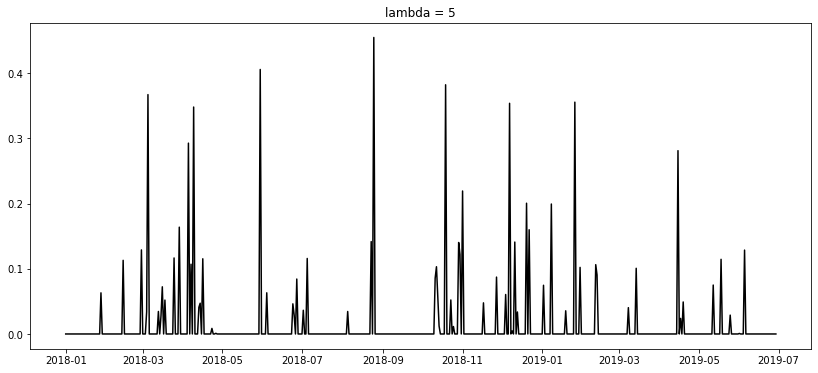

In [1004]:
lambd = [.05]
alpha = [5]

# for results do OO and used the fuse lasso as previously found

model = fuse_lasso(A.matr, A.delay_matr, lambd, alpha)
segments = list(model.generate_segments(.2, True)['dates'])

In [1005]:
lag = 1
var_model = VAR_model(A, B, segments, carrier, lag)

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



ORD


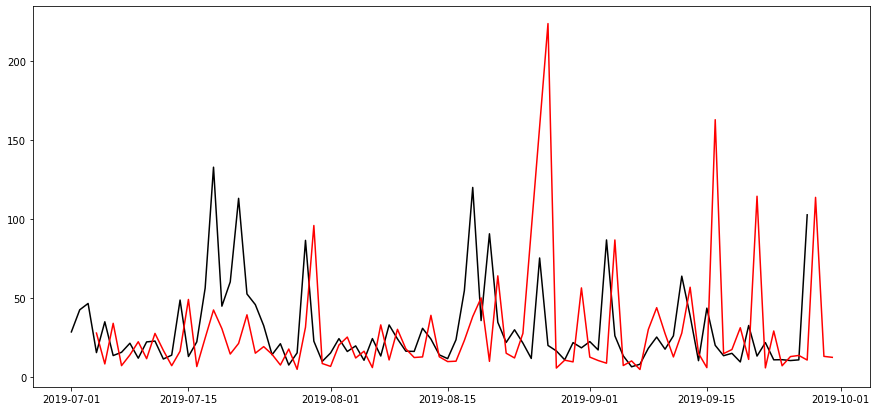

DTW


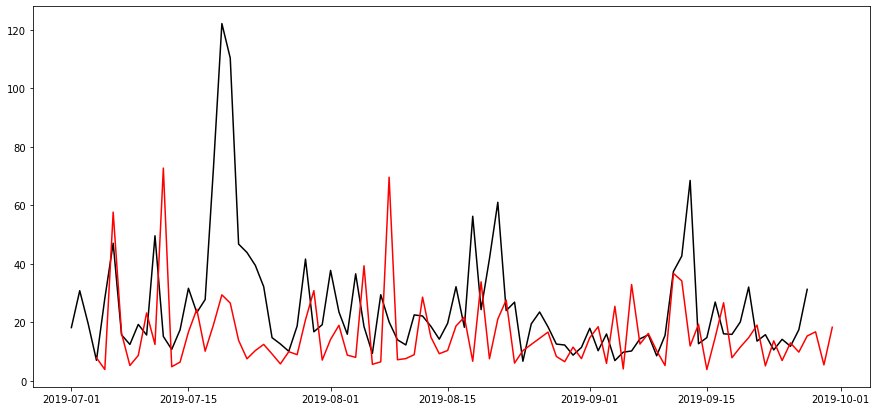

MSP


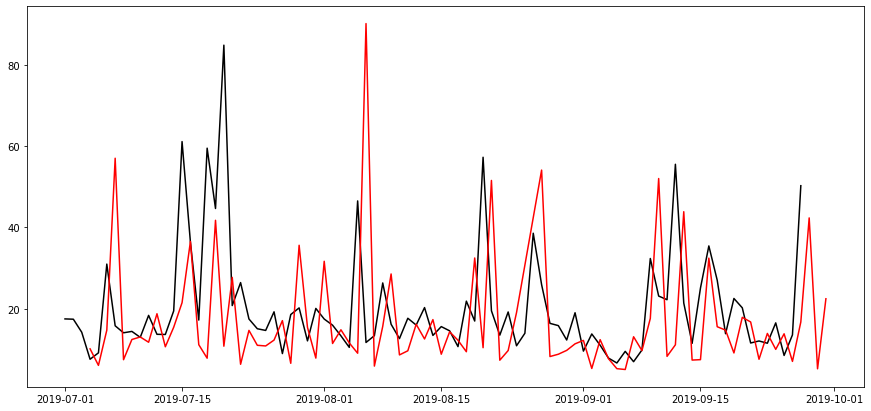

ATL


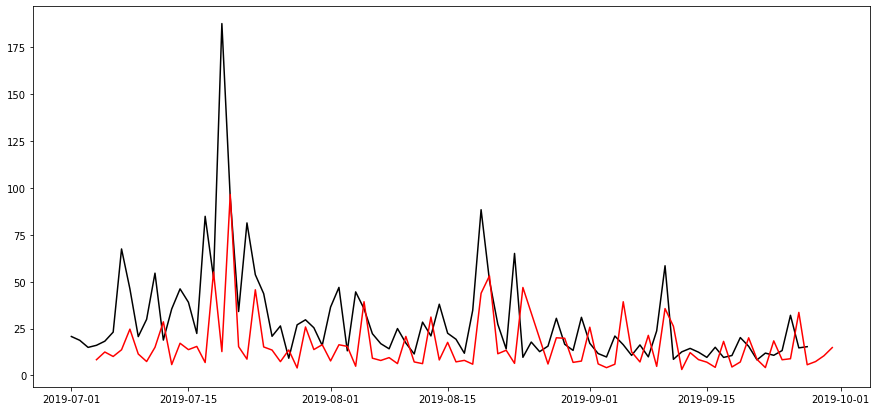

DFW


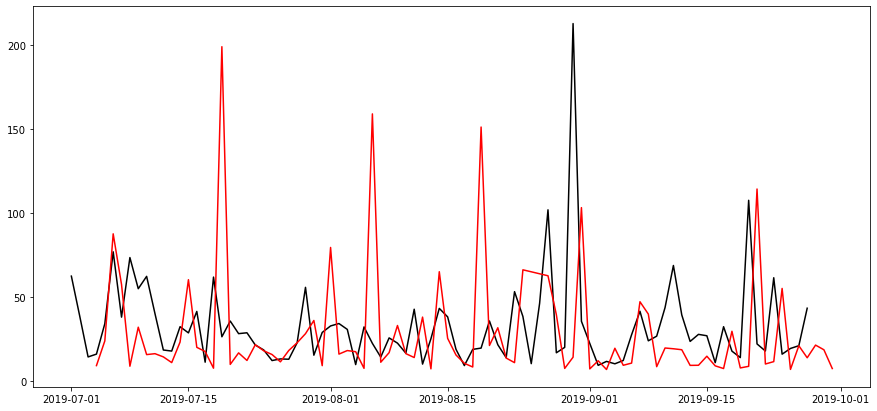

DEN


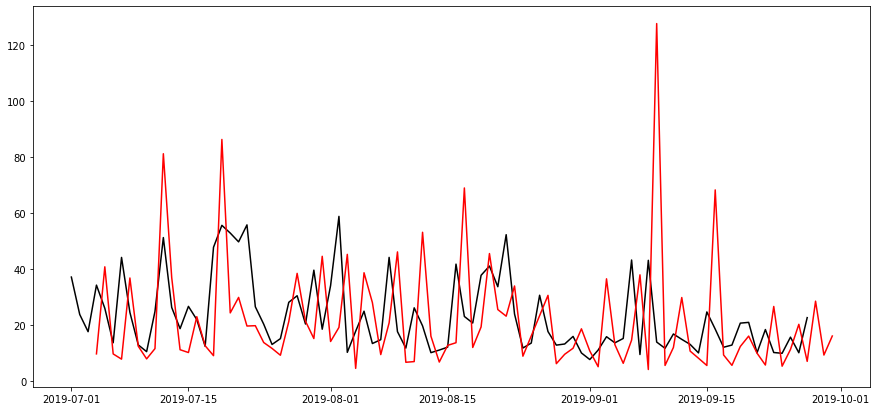

SLC


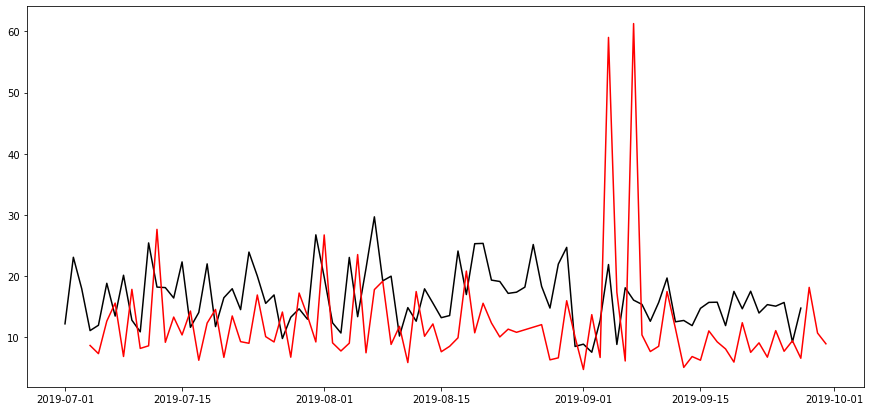

PHX


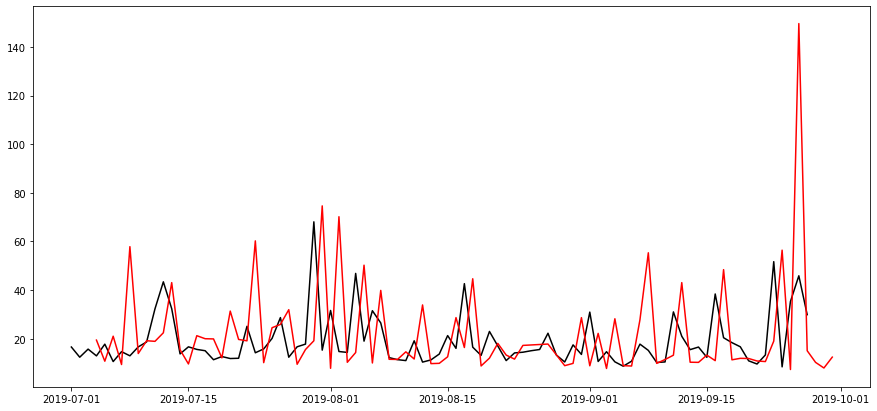

LAX


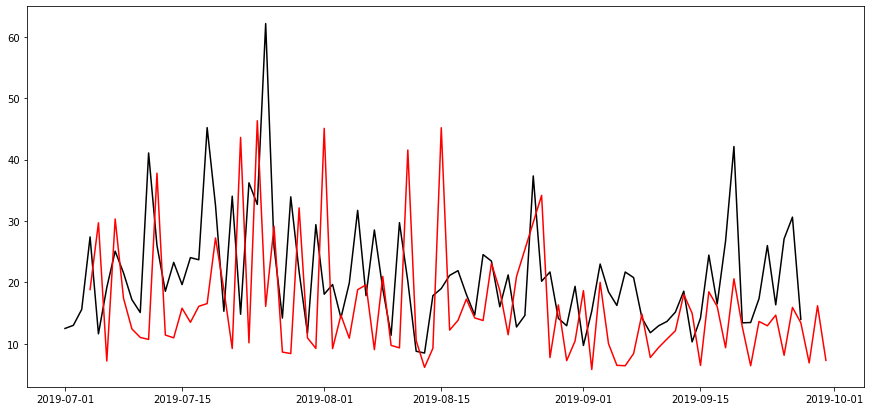

SFO


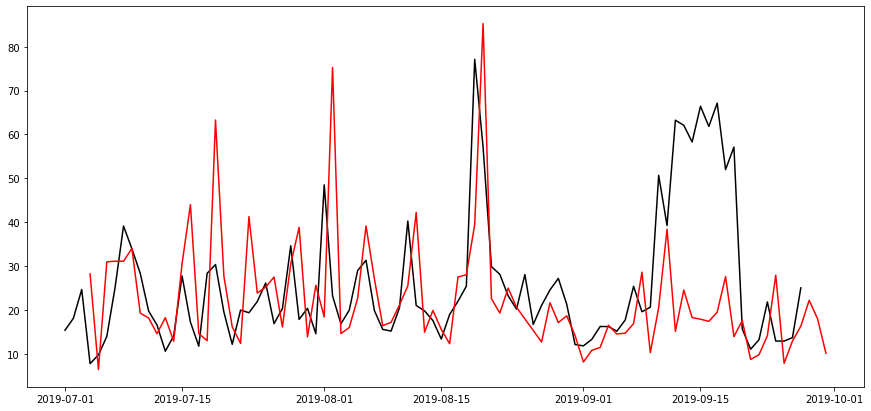

In [1006]:
var_model.plot_results()

In [961]:
"""df = []
for CARRIER in CODES:
    num_airports = 10
    carrier = CARRIER

    # training data
    A = prep_delay_data(MY_DATA, carrier, num_airports)
    # test data
    B = prep_delay_data(Q3_DATA, carrier, num_airports)
    
    segments = [pd.to_datetime('2018-07-01'), pd.to_datetime('2018-10-01')]

    lag = 1
    var_model = VAR_model(A, B, segments, carrier, lag)
    pred_df = var_model.observed.iloc[3:]
    obs_df = var_model.predicted.iloc[:-3]
    
    print('-'*50)

    aps = A.delay_matr.columns
    for air in aps:
        k = pred_df[air].to_numpy()
        o = obs_df[air].to_numpy()
        
        print(air, np.square(np.subtract(k, o)).mean())
    print('-'*50)
    title = 'pred_{}.csv'.format(carrier)
    pred_df.to_csv(title, encoding='utf-8', index=False)
    
    q  = var_model.observed.iloc[3:].to_numpy().flatten()
    s = var_model.predicted.iloc[:-3].to_numpy().flatten()
    mse = np.square(np.subtract(q, s)).mean()
    df.append({'ap': CARRIER, 'mse': mse})
    print(CARRIER, mse)"""

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
MDW 203.13325244797284
ATL 155.12380976065847
BWI 333.6164592038794
DAL 224.41269202229938
DEN 197.98955841769506
HOU 336.9297809643642
MCO 204.70962631389267
PHX 381.39206725824874
LAS 70.60528922783212
LAX 105.36286117786425
--------------------------------------------------
WN 221.32753967947073


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
ATL 217.1804761776886
MCO 2275.4765062159413
DTW 230.3574393849304
JFK 1464.9238732804274
LGA 2376.6943232881413
MSP 462.4582983953902
BOS 1428.9049766620303
SLC 108.80261630257837
LAX 64.07619074171075
SEA 152.99632153961855
--------------------------------------------------
DL 878.1871021988457


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
DFW 326.11738532464
ORD 803.0645000808788
PHX 220.43236377048325
CLT 227.66128293873032
MIA 193.6648000553681
DCA 865.0233793713774
LAX 83.85821946044415
PHL 334.48819330205805
LGA 618.8883801096624
BOS 426.613718630948
--------------------------------------------------
AA 409.98122230445904


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
ORD 1423.720185592137
DTW 535.7478638011147
MSP 355.0521963994128
ATL 810.3728936699332
DFW 1769.0001077730233
DEN 524.9549144766288
SLC 66.87548893653718
PHX 340.0651873541109
LAX 196.89581610432424
SFO 290.81771730907485
--------------------------------------------------
OO 631.3502371416297


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
ORD 1287.24372771917
IAD 883.9070874524741
EWR 895.1133484176721
BOS 1282.2058577757239
DEN 308.16468742513086
IAH 532.4857653453809
MCO 721.0500832936165
LAS 390.91376566186767
LAX 220.19584848989217
SFO 90.40188104003033
--------------------------------------------------
UA 661.1682052620957


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
DCA 559.5552891934001
PHL 478.55272860523735
EWR 1177.635264951725
LGA 1185.302593887362
CMH 638.002371950536
CLT 693.5431403359934
IND 286.27871077933565
ORD 2568.0696963145347
MIA 227.96307836150484
IAH 781.7747741436202
--------------------------------------------------
YX 859.6677648523248


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
BOS 395.0902915391072
JFK 562.5624016020729
EWR 1476.224086590703
DCA 3840.633372903667
MCO 1079.3566936942375
PBI 2504.23516360506
FLL 1129.9300743717843
SJU 731.9805348612476
LGB 695.799397328307
LAX 899.4021971858134
--------------------------------------------------
B6 1331.5214213682


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
ORD 481.3250401334915
CVG 37906.93643534568
CMH 13670.920007839082
CLE 2671.433275990239
SGF 734.0105340091708
XNA 1365.2240501758722
LGA 931.3699925091389
JFK 25901.505100875147
DFW 175.9041289965836
MIA 209.98221058017717
--------------------------------------------------
MQ 8404.861077645455


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
CLT 229.79228406277815
GSP 12490.42784248637
TYS 26339.757794129186
SAV 908.5596632010327
ORF 6064.664324295048
DCA 1860.2452529816849
CVG 88948.43084901536
BHM 4078.374812583245
DAY 6874.1844838625875
PHL 2324.3913031721568
--------------------------------------------------
OH 15011.882860978945


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
SEA 43.38880152014857
PDX 99.97119594987882
SFO 280.5846826781068
SJC 757.4648111895217
LAS 513.1830719368527
JNU 866.3517602730266
LAX 418.3987942072288
SAN 291.94037948819556
ANC 66.97802368235648
JFK 1853.31757354239
--------------------------------------------------
AS 519.1579094467705


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
ATL 245.09801854079717
TYS 1300.6299803858099
RDU 5066.758153655589
CVG 595.7990444667987
PIT 40915.06593801342
DTW 899.9331646281468
JFK 11451.758494245954
LGA 4741.669730531283
MSP 589.1730163282896
BOS 13125.10557697862
--------------------------------------------------
9E 7893.099111777469


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
DFW 326.56792414798633
OKC 12689.131945699253
IAH 951.7820241517458
MAF 1396.1821761346825
ELP 3178.5557837885626
ABQ 4036.6020488822282
TUS 28442.74316944142
PHX 1151.9563160899709
DTW 3687.795228632659
IAD 852.7297435730961
--------------------------------------------------
YV 5671.4046360541615


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
FLL 324.0331236137584
MCO 781.3539892192108
ATL 1401.0588651899398
BWI 837.1831430580066
IAH 637.1409567960806
DFW 4069.9104340600416
DTW 558.110323111025
ORD 1131.2378524989379
LAS 286.1521178131433
LAX 838.2019115087844
--------------------------------------------------
NK 1086.438271686893


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
IAH 1408.1312105910738
DFW 75710.85783202876
BTR 214.53899467464444
ATL 1613.4286873970918
ORD 456496.1393403274
CLE 3327.6037764215953
RIC 28909.9881862376
DCA 203380.08375181106
EWR 1615.6158120863663
LGA 768.8867574187279
--------------------------------------------------
EV 77344.52743489941


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
DEN 747.072937815311
LAS 1278.8302743784545
AUS 1667.269524324113
ORD 3740.4157588124485
CVG 3537.392923476833
ATL 7516.712036523875
TPA 3495.634959509988
MCO 973.026498562818
PHL 1301.3481316855398
RSW 33651.078068564944
--------------------------------------------------
F9 5790.878111365433


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWa

--------------------------------------------------
SFB 204.13575947811546
AVL 13579.610687310045
CVG 1091.743951386981
IND 5919.007933717046
LAS 411.54119188775354
PIE 1273.4655040077732
AZA 16004.659380670666
PGD 1432.4452738961947
FLL 850.5476490664269
BLI 687.113407818981
--------------------------------------------------
G4 4145.427073924


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Landon\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning:


A value is trying to be set on a copy o

--------------------------------------------------
HNL 39.583985960442234
OGG 51.911210842081275
LIH 63.51014952044276
KOA 107.03172720904148
ITO 56.59259391403845
SFO 4807.783162063206
OAK 735.9645897479121
LAX 1443.9228871813743
SEA 1543.371469747084
LAS 1589.2420570705206
--------------------------------------------------
HA 1043.8913833256142
